things to note: only did seasonal stuff for US east - plan on making functions and applying to other locations later 

some daily data starts at 12 hr and some starts at 00hr so we end up with double time when merging and nans - this is why I have to do the dropna and nanquantile in the quantile_occurance function 



In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
import intake 
import pprint
from src.LE_LoadAndMerge import *
from scipy import stats
import warnings
warnings.filterwarnings("ignore")

In [2]:
def get_stats(X):
    return np.round(np.nanmean(X),2), np.round(np.nanmedian(X),2), np.round(np.nanstd(X),2), np.round(stats.skew(X,nan_policy='omit'),2)



In [3]:
def quantile_occurance(hist,future,q):
    
    quantile = np.round(np.nanquantile(hist,q),2)
    occurance = np.count_nonzero(future >= quantile)
    percent = np.round((occurance/len(future.dropna(dim='time'))*100),2)
    
    return quantile,percent

### Load Data 

In [4]:
USeast = MultiModelLargeEnsemble(models=['CanESM5','cesm_lens','ACCESS-ESM1-5','MIROC6','MPI-ESM1-2-LR'],
                              variable='tas', granularity='day', lat=41.3, lon=-72.5,
                              bucket='climateai_data_repository', path='tmp/internal_variability',load=True)

In [5]:
USwest = MultiModelLargeEnsemble(models=['CanESM5','cesm_lens','ACCESS-ESM1-5','MIROC6','MPI-ESM1-2-LR'],
                              variable='tas', granularity='day', lat=37.7,lon=-122.4,
                              bucket='climateai_data_repository', path='tmp/internal_variability',load=True)

In [6]:
iceland = MultiModelLargeEnsemble(models=['CanESM5','cesm_lens','ACCESS-ESM1-5','MIROC6','MPI-ESM1-2-LR'],
                              variable='tas', granularity='day', lat=65,lon=-19,
                              bucket='climateai_data_repository', path='tmp/internal_variability',load=True)

In [7]:
europe = MultiModelLargeEnsemble(models=['CanESM5','cesm_lens','ACCESS-ESM1-5','MIROC6','MPI-ESM1-2-LR'],
                              variable='tas', granularity='day', lat=51,lon=10.5,
                              bucket='climateai_data_repository', path='tmp/internal_variability',load=True)

In [8]:
australia = MultiModelLargeEnsemble(models=['CanESM5','cesm_lens','ACCESS-ESM1-5','MIROC6','MPI-ESM1-2-LR'],
                              variable='tas', granularity='day', lat=-25.2,lon=133.7,
                              bucket='climateai_data_repository', path='tmp/internal_variability',load=True)

In [9]:
tropics = MultiModelLargeEnsemble(models=['CanESM5','cesm_lens','ACCESS-ESM1-5','MIROC6','MPI-ESM1-2-LR'],
                              variable='tas', granularity='day', lat=3.9,lon=-53.1,
                              bucket='climateai_data_repository', path='tmp/internal_variability',load=True)

In [10]:
USwest_hist = USwest.hist.mean(dim='member').tas
USeast_hist = USeast.hist.mean(dim='member').tas
iceland_hist = iceland.hist.mean(dim='member').tas
europe_hist = europe.hist.mean(dim='member').tas
australia_hist = australia.hist.mean(dim='member').tas
tropics_hist = tropics.hist.mean(dim='member').tas

In [11]:
USwest_future = USwest.future.mean(dim='member').tas
USeast_future = USeast.future.mean(dim='member').tas
iceland_future = iceland.future.mean(dim='member').tas
europe_future = europe.future.mean(dim='member').tas
australia_future = australia.future.mean(dim='member').tas
tropics_future = tropics.future.mean(dim='member').tas

## US East

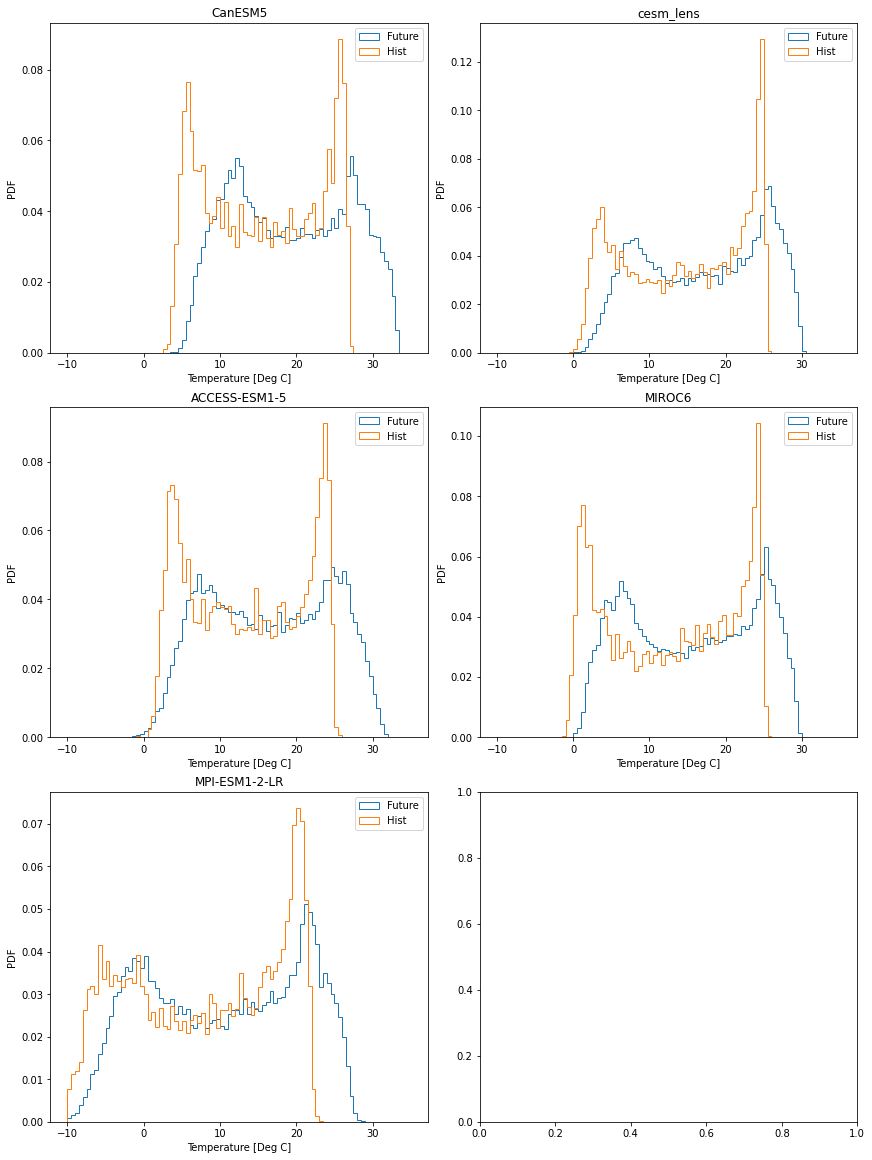

In [15]:
# make step PDF for all models 
dbins, bmin, bmax = 0.5, -10, 35
bins = np.arange(bmin,bmax+dbins,dbins)

fig, ax = plt.subplots(nrows=3, ncols=2, constrained_layout=True,figsize=(12,16))
axes = [ax[0,0],ax[0,1],ax[1,0],ax[1,1],ax[2,0],ax[2,1]]
models=['CanESM5','cesm_lens','ACCESS-ESM1-5','MIROC6','MPI-ESM1-2-LR']
for axe,model in zip(axes,models):
    axe.hist(USeast_future.sel(model=model),density=True, bins=bins,histtype='step',label='Future');
    axe.hist(USeast_hist.sel(model=model),density=True,bins=bins,histtype='step',label='Hist');
    axe.set_xlabel('Temperature [Deg C]')
    axe.set_ylabel('PDF')
    axe.set_title(model)
    axe.legend()
# plt.text(0.05,0.05,
#          (f'Mean {get_stats(future)[0]} \n Median {get_stats(future)[1]} \n Std {get_stats(future)[2]} \n Skew {get_stats(future)[3]}'.format()),
#          ha='left',va='center',fontsize=11)


In [17]:
Q99 = []
Q99_percent = []
Q95 = []
Q95_percent = []
Q90 = []
Q90_percent = []
models = ['CanESM5','cesm_lens','ACCESS-ESM1-5','MIROC6','MPI-ESM1-2-LR']
for model in models:
    
    Q99.append(quantile_occurance(USeast_hist.sel(model=model),
                       USeast_future.sel(model=model),q=0.99)[0])
    Q99_percent.append(quantile_occurance(USeast_hist.sel(model=model),
                       USeast_future.sel(model=model),q=0.99)[1])
    Q95.append(quantile_occurance(USeast_hist.sel(model=model),
                       USeast_future.sel(model=model),q=0.95)[0])
    Q95_percent.append(quantile_occurance(USeast_hist.sel(model=model),
                       USeast_future.sel(model=model),q=0.95)[1])
    Q90.append(quantile_occurance(USeast_hist.sel(model=model),
                       USeast_future.sel(model=model),q=0.90)[0])
    Q90_percent.append(quantile_occurance(USeast_hist.sel(model=model),
                       USeast_future.sel(model=model),q=0.90)[1])

In [26]:
df = pd.DataFrame(data=[models,Q99,Q99_percent,Q95,Q95_percent,Q90,Q90_percent])

In [27]:
df = df.T

In [28]:
df = df.rename(columns={0:'Models',1:'99th Quantile [Deg C]',
                        2:'99thQ % Occurance',3:'95th Quantile [Deg C]',
                        4:'95thQ % Occurance',
                        5:'90th Quantile [Deg C]',6:'90thQ % Occurance'})

In [29]:
df

,Models,99th Quantile [Deg C],99thQ % Occurance,95th Quantile [Deg C],95thQ % Occurance,90th Quantile [Deg C],90thQ % Occurance
0,CanESM5,26.68,23.11,26.07,25.68,25.51,27.92
1,cesm_lens,25.17,21.93,24.78,24.18,24.39,26.33
2,ACCESS-ESM1-5,24.68,20.43,24.06,23.34,23.52,25.84
3,MIROC6,24.83,18.32,24.33,20.98,23.82,23.18
4,MPI-ESM1-2-LR,21.74,16.83,20.93,20.91,20.24,23.9


#### Define Seasons

In [30]:
USeast_hist = USeast_hist.T
USeast_future = USeast_future.T

In [31]:
JJA_hist = USeast_hist.loc[USeast_hist['time.month'].isin([6, 7, 8])]  # summer
SON_hist = USeast_hist.loc[USeast_hist['time.month'].isin([9, 10, 11])]  # fall
DJF_hist = USeast_hist.loc[USeast_hist['time.month'].isin([12, 1, 2])]  # winter
MAM_hist = USeast_hist.loc[USeast_hist['time.month'].isin([3, 4, 5])]  # spring

JJA_future = USeast_future.loc[USeast_future['time.month'].isin([6, 7, 8])]  # summer
SON_future = USeast_future.loc[USeast_future['time.month'].isin([9, 10, 11])]  # fall
DJF_future = USeast_future.loc[USeast_future['time.month'].isin([12, 1, 2])]  # winter
MAM_future = USeast_future.loc[USeast_future['time.month'].isin([3, 4, 5])]  # spring

#### Look at summer

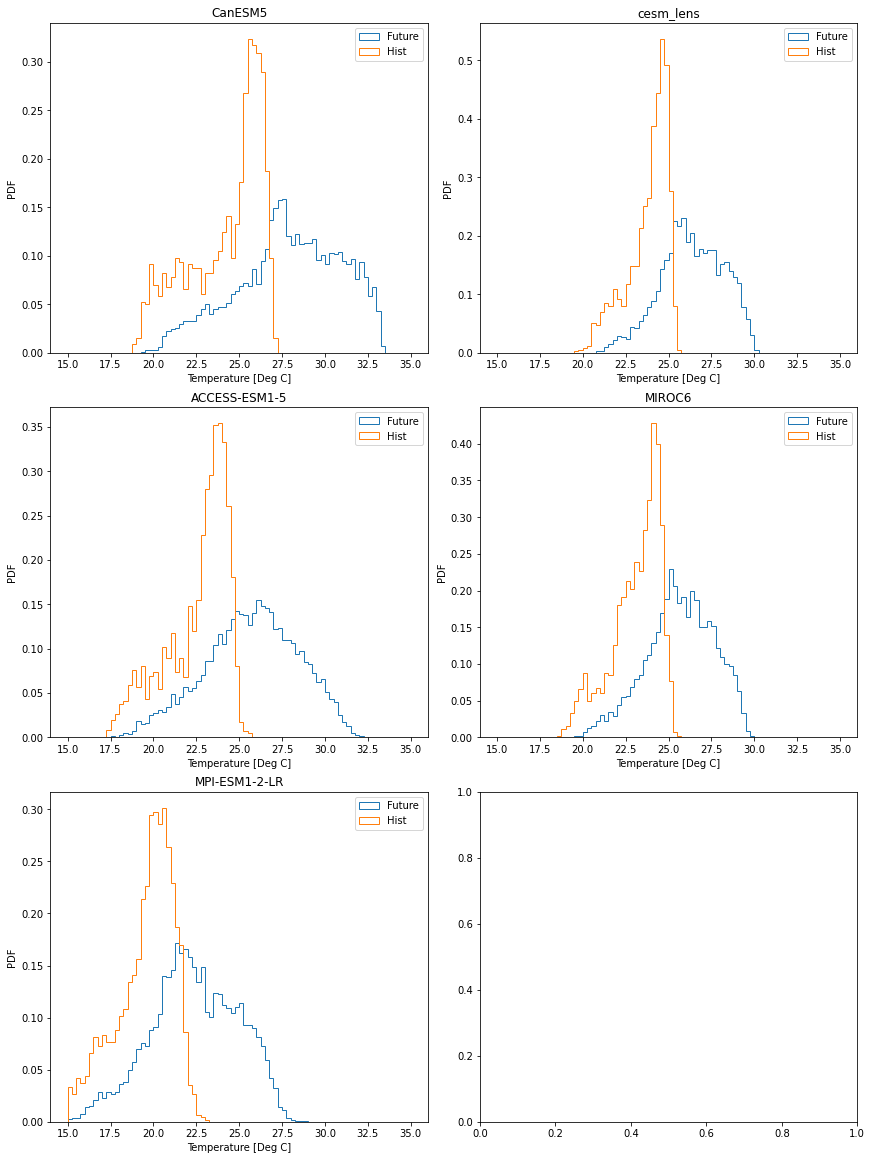

In [32]:
# make step PDF for all models 
dbins, bmin, bmax = 0.25, 15, 35
bins = np.arange(bmin,bmax+dbins,dbins)

fig, ax = plt.subplots(nrows=3, ncols=2, constrained_layout=True,figsize=(12,16))
axes = [ax[0,0],ax[0,1],ax[1,0],ax[1,1],ax[2,0],ax[2,1]]
models=['CanESM5','cesm_lens','ACCESS-ESM1-5','MIROC6','MPI-ESM1-2-LR']
for axe,model in zip(axes,models):
    axe.hist(JJA_future.sel(model=model),density=True, bins=bins,histtype='step',label='Future');
    axe.hist(JJA_hist.sel(model=model),density=True,bins=bins,histtype='step',label='Hist');
    axe.set_xlabel('Temperature [Deg C]')
    axe.set_ylabel('PDF')
    axe.set_title(model)
    axe.legend()

In [33]:
Q99 = []
Q99_percent = []
Q95 = []
Q95_percent = []
Q90 = []
Q90_percent = []
models = ['CanESM5','cesm_lens','ACCESS-ESM1-5','MIROC6','MPI-ESM1-2-LR']
for model in models:
    
    Q99.append(quantile_occurance(JJA_hist.sel(model=model),
                       JJA_future.sel(model=model),q=0.99)[0])
    Q99_percent.append(quantile_occurance(JJA_hist.sel(model=model),
                       JJA_future.sel(model=model),q=0.99)[1])
    Q95.append(quantile_occurance(JJA_hist.sel(model=model),
                       JJA_future.sel(model=model),q=0.95)[0])
    Q95_percent.append(quantile_occurance(JJA_hist.sel(model=model),
                       JJA_future.sel(model=model),q=0.95)[1])
    Q90.append(quantile_occurance(JJA_hist.sel(model=model),
                       JJA_future.sel(model=model),q=0.90)[0])
    Q90_percent.append(quantile_occurance(JJA_hist.sel(model=model),
                       JJA_future.sel(model=model),q=0.90)[1])

In [34]:
df = pd.DataFrame(data=[models,Q99,Q99_percent,Q95,Q95_percent,Q90,Q90_percent])
df = df.T
df = df.rename(columns={0:'Models',1:'99th Quantile [Deg C]',
                        2:'99thQ % Occurance',3:'95th Quantile [Deg C]',
                        4:'95thQ % Occurance',
                        5:'90th Quantile [Deg C]',6:'90thQ % Occurance'})
df

,Models,99th Quantile [Deg C],99thQ % Occurance,95th Quantile [Deg C],95thQ % Occurance,90th Quantile [Deg C],90thQ % Occurance
0,CanESM5,26.87,66.18,26.64,69.0,26.42,71.22
1,cesm_lens,25.38,70.5,25.13,75.19,24.98,77.67
2,ACCESS-ESM1-5,24.94,62.42,24.61,66.97,24.37,69.91
3,MIROC6,25.08,62.73,24.77,68.98,24.59,72.31
4,MPI-ESM1-2-LR,22.24,50.97,21.68,59.96,21.41,64.7


#### Look at winter

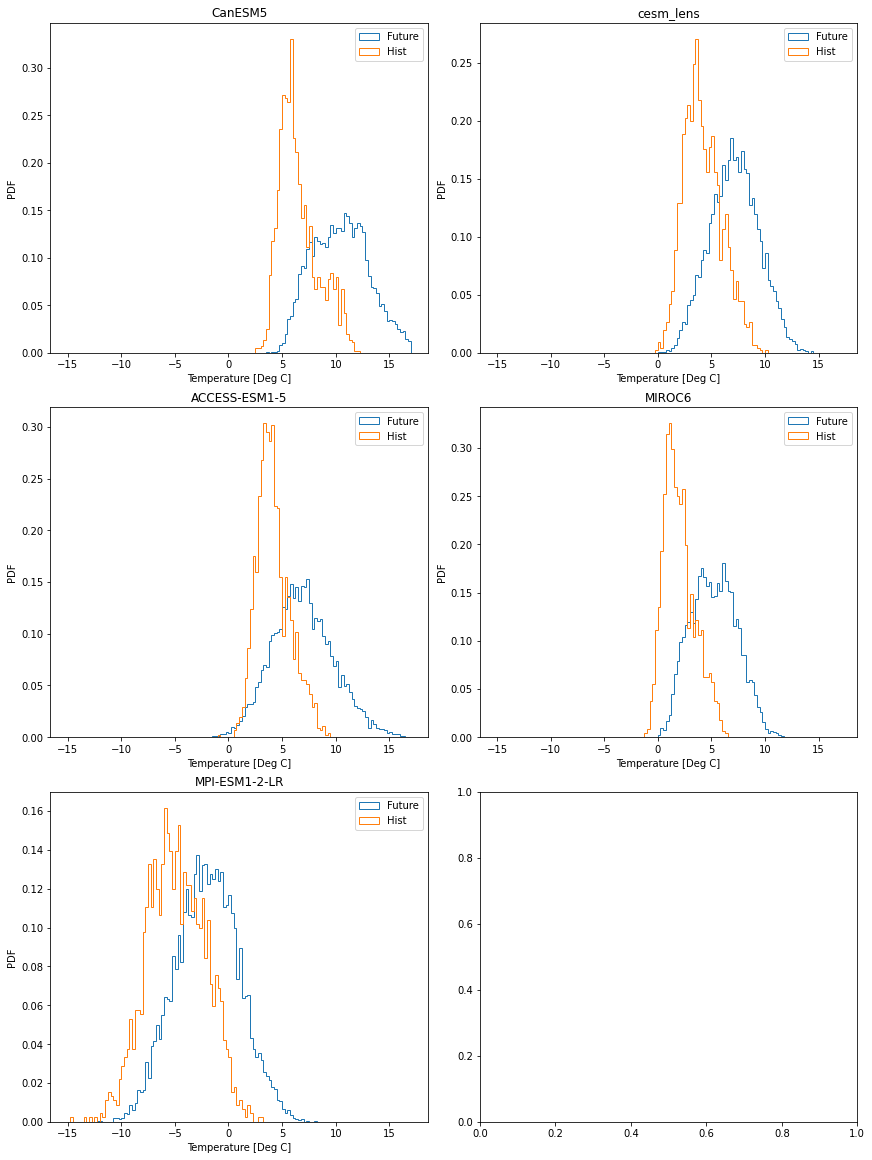

In [35]:
# make step PDF for all models 
dbins, bmin, bmax = 0.25, -15, 17
bins = np.arange(bmin,bmax+dbins,dbins)

fig, ax = plt.subplots(nrows=3, ncols=2, constrained_layout=True,figsize=(12,16))
axes = [ax[0,0],ax[0,1],ax[1,0],ax[1,1],ax[2,0],ax[2,1]]
models=['CanESM5','cesm_lens','ACCESS-ESM1-5','MIROC6','MPI-ESM1-2-LR']
for axe,model in zip(axes,models):
    axe.hist(DJF_future.sel(model=model),density=True, bins=bins,histtype='step',label='Future');
    axe.hist(DJF_hist.sel(model=model),density=True,bins=bins,histtype='step',label='Hist');
    axe.set_xlabel('Temperature [Deg C]')
    axe.set_ylabel('PDF')
    axe.set_title(model)
    axe.legend()

In [36]:
Q99 = []
Q99_percent = []
Q95 = []
Q95_percent = []
Q90 = []
Q90_percent = []
models = ['CanESM5','cesm_lens','ACCESS-ESM1-5','MIROC6','MPI-ESM1-2-LR']
for model in models:
    
    Q99.append(quantile_occurance(DJF_hist.sel(model=model),
                       DJF_future.sel(model=model),q=0.99)[0])
    Q99_percent.append(quantile_occurance(DJF_hist.sel(model=model),
                       DJF_future.sel(model=model),q=0.99)[1])
    Q95.append(quantile_occurance(DJF_hist.sel(model=model),
                       DJF_future.sel(model=model),q=0.95)[0])
    Q95_percent.append(quantile_occurance(DJF_hist.sel(model=model),
                       DJF_future.sel(model=model),q=0.95)[1])
    Q90.append(quantile_occurance(DJF_hist.sel(model=model),
                       DJF_future.sel(model=model),q=0.90)[0])
    Q90_percent.append(quantile_occurance(DJF_hist.sel(model=model),
                       DJF_future.sel(model=model),q=0.90)[1])

In [37]:
df = pd.DataFrame(data=[models,Q99,Q99_percent,Q95,Q95_percent,Q90,Q90_percent])
df = df.T
df = df.rename(columns={0:'Models',1:'99th Quantile [Deg C]',
                        2:'99thQ % Occurance',3:'95th Quantile [Deg C]',
                        4:'95thQ % Occurance',
                        5:'90th Quantile [Deg C]',6:'90thQ % Occurance'})
df

,Models,99th Quantile [Deg C],99thQ % Occurance,95th Quantile [Deg C],95thQ % Occurance,90th Quantile [Deg C],90thQ % Occurance
0,CanESM5,11.06,41.98,10.19,53.49,9.56,61.58
1,cesm_lens,8.65,25.65,7.45,44.59,6.62,58.75
2,ACCESS-ESM1-5,8.18,31.72,7.16,44.78,6.41,55.37
3,MIROC6,5.66,42.48,4.84,54.94,4.15,66.18
4,MPI-ESM1-2-LR,0.99,15.64,-0.53,31.36,-1.29,41.21


#### Fall 

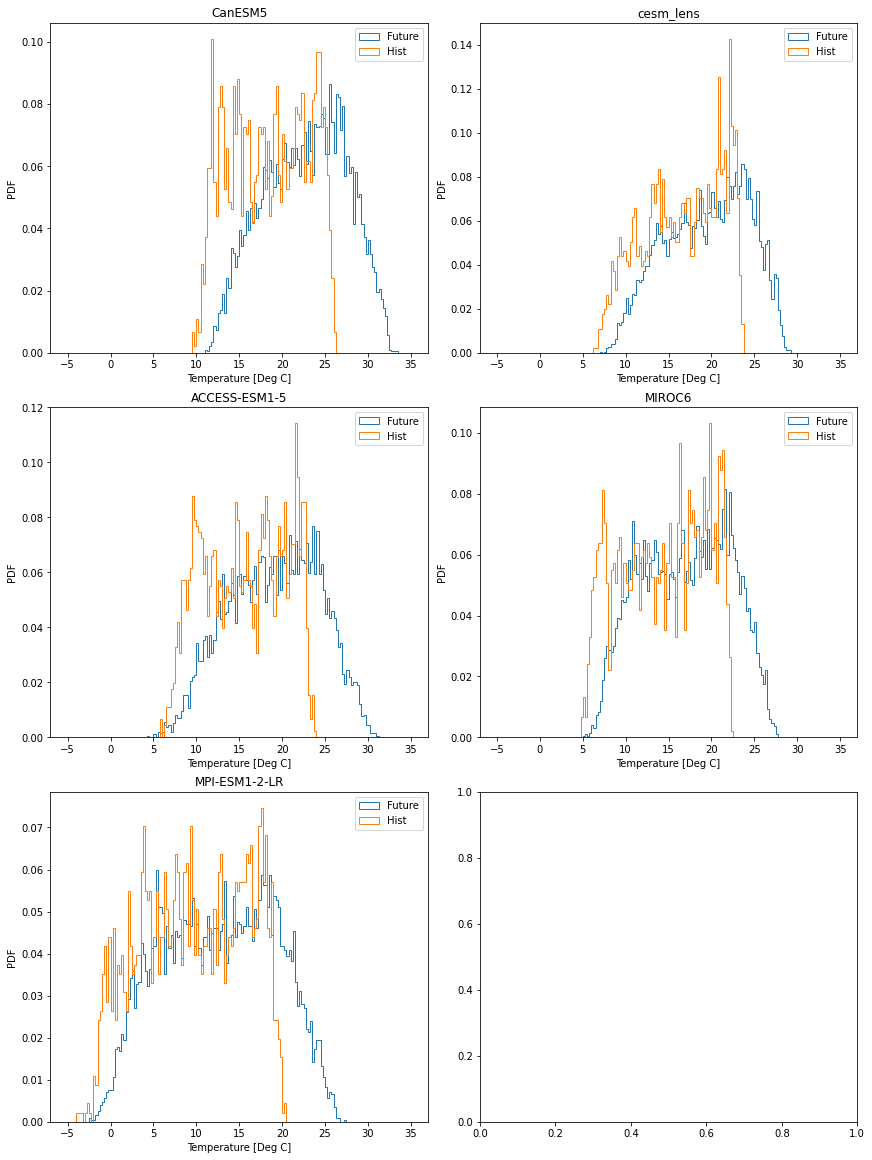

In [38]:
# make step PDF for all models 
dbins, bmin, bmax = 0.25, -5, 35
bins = np.arange(bmin,bmax+dbins,dbins)

fig, ax = plt.subplots(nrows=3, ncols=2, constrained_layout=True,figsize=(12,16))
axes = [ax[0,0],ax[0,1],ax[1,0],ax[1,1],ax[2,0],ax[2,1]]
models=['CanESM5','cesm_lens','ACCESS-ESM1-5','MIROC6','MPI-ESM1-2-LR']
for axe,model in zip(axes,models):
    axe.hist(SON_future.sel(model=model),density=True, bins=bins,histtype='step',label='Future');
    axe.hist(SON_hist.sel(model=model),density=True,bins=bins,histtype='step',label='Hist');
    axe.set_xlabel('Temperature [Deg C]')
    axe.set_ylabel('PDF')
    axe.set_title(model)
    axe.legend()

In [39]:
Q99 = []
Q99_percent = []
Q95 = []
Q95_percent = []
Q90 = []
Q90_percent = []
models = ['CanESM5','cesm_lens','ACCESS-ESM1-5','MIROC6','MPI-ESM1-2-LR']
for model in models:
    
    Q99.append(quantile_occurance(SON_hist.sel(model=model),
                       SON_future.sel(model=model),q=0.99)[0])
    Q99_percent.append(quantile_occurance(SON_hist.sel(model=model),
                       SON_future.sel(model=model),q=0.99)[1])
    Q95.append(quantile_occurance(SON_hist.sel(model=model),
                       SON_future.sel(model=model),q=0.95)[0])
    Q95_percent.append(quantile_occurance(SON_hist.sel(model=model),
                       SON_future.sel(model=model),q=0.95)[1])
    Q90.append(quantile_occurance(SON_hist.sel(model=model),
                       SON_future.sel(model=model),q=0.90)[0])
    Q90_percent.append(quantile_occurance(SON_hist.sel(model=model),
                       SON_future.sel(model=model),q=0.90)[1])

In [40]:
df = pd.DataFrame(data=[models,Q99,Q99_percent,Q95,Q95_percent,Q90,Q90_percent])
df = df.T
df = df.rename(columns={0:'Models',1:'99th Quantile [Deg C]',
                        2:'99thQ % Occurance',3:'95th Quantile [Deg C]',
                        4:'95thQ % Occurance',
                        5:'90th Quantile [Deg C]',6:'90thQ % Occurance'})
df

,Models,99th Quantile [Deg C],99thQ % Occurance,95th Quantile [Deg C],95thQ % Occurance,90th Quantile [Deg C],90thQ % Occurance
0,CanESM5,25.63,31.45,25.0,35.78,24.37,40.48
1,cesm_lens,23.29,26.34,22.8,30.08,22.31,33.81
2,ACCESS-ESM1-5,23.0,26.35,22.38,30.5,21.79,34.22
3,MIROC6,21.94,20.24,21.34,24.69,20.78,28.34
4,MPI-ESM1-2-LR,19.51,17.01,18.4,22.81,17.67,26.71


#### spring

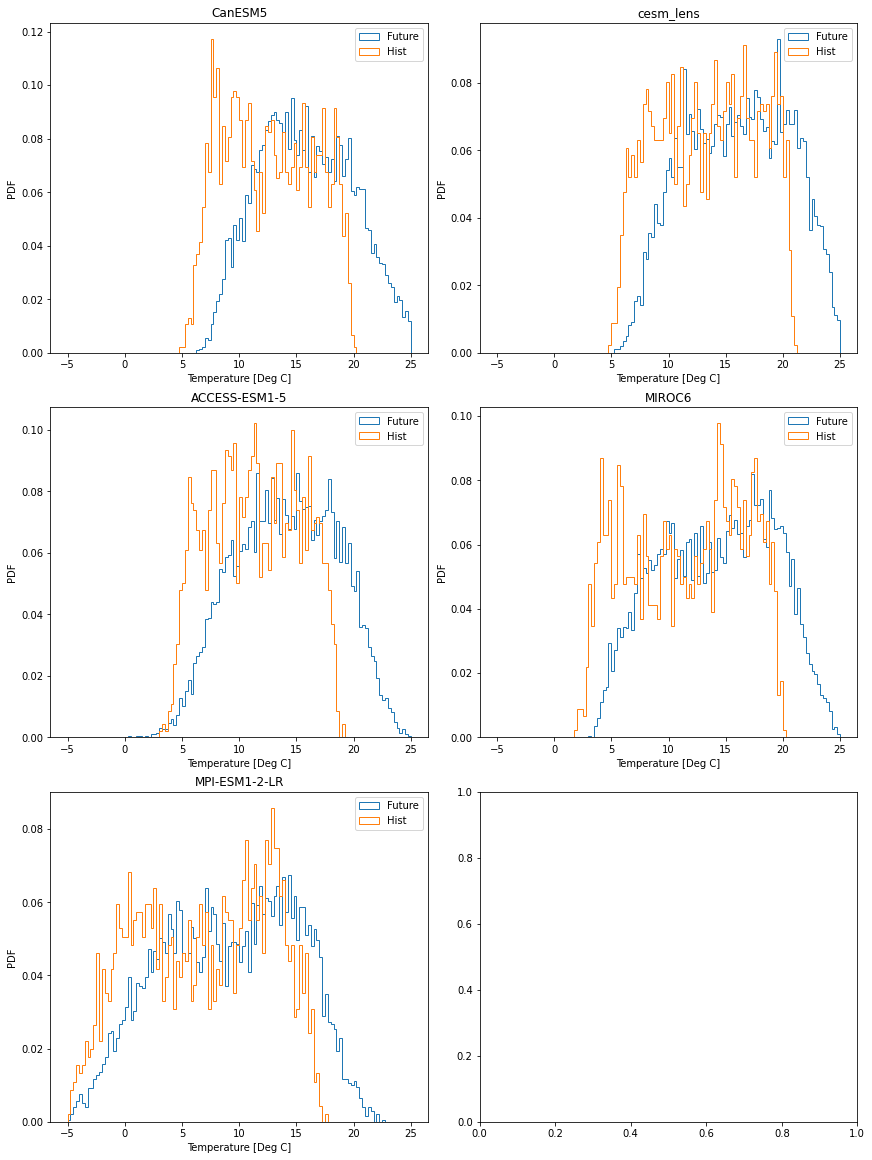

In [41]:
# make step PDF for all models 
dbins, bmin, bmax = 0.25, -5, 25
bins = np.arange(bmin,bmax+dbins,dbins)

fig, ax = plt.subplots(nrows=3, ncols=2, constrained_layout=True,figsize=(12,16))
axes = [ax[0,0],ax[0,1],ax[1,0],ax[1,1],ax[2,0],ax[2,1]]
models=['CanESM5','cesm_lens','ACCESS-ESM1-5','MIROC6','MPI-ESM1-2-LR']
for axe,model in zip(axes,models):
    axe.hist(MAM_future.sel(model=model),density=True, bins=bins,histtype='step',label='Future');
    axe.hist(MAM_hist.sel(model=model),density=True,bins=bins,histtype='step',label='Hist');
    axe.set_xlabel('Temperature [Deg C]')
    axe.set_ylabel('PDF')
    axe.set_title(model)
    axe.legend()

In [42]:
Q99 = []
Q99_percent = []
Q95 = []
Q95_percent = []
Q90 = []
Q90_percent = []
models = ['CanESM5','cesm_lens','ACCESS-ESM1-5','MIROC6','MPI-ESM1-2-LR']
for model in models:
    
    Q99.append(quantile_occurance(MAM_hist.sel(model=model),
                       MAM_future.sel(model=model),q=0.99)[0])
    Q99_percent.append(quantile_occurance(MAM_hist.sel(model=model),
                       MAM_future.sel(model=model),q=0.99)[1])
    Q95.append(quantile_occurance(MAM_hist.sel(model=model),
                       MAM_future.sel(model=model),q=0.95)[0])
    Q95_percent.append(quantile_occurance(MAM_hist.sel(model=model),
                       MAM_future.sel(model=model),q=0.95)[1])
    Q90.append(quantile_occurance(MAM_hist.sel(model=model),
                       MAM_future.sel(model=model),q=0.90)[0])
    Q90_percent.append(quantile_occurance(MAM_hist.sel(model=model),
                       MAM_future.sel(model=model),q=0.90)[1])

In [43]:
df = pd.DataFrame(data=[models,Q99,Q99_percent,Q95,Q95_percent,Q90,Q90_percent])
df = df.T
df = df.rename(columns={0:'Models',1:'99th Quantile [Deg C]',
                        2:'99thQ % Occurance',3:'95th Quantile [Deg C]',
                        4:'95thQ % Occurance',
                        5:'90th Quantile [Deg C]',6:'90thQ % Occurance'})
df

,Models,99th Quantile [Deg C],99thQ % Occurance,95th Quantile [Deg C],95thQ % Occurance,90th Quantile [Deg C],90thQ % Occurance
0,CanESM5,19.47,21.46,18.74,26.79,18.06,31.67
1,cesm_lens,20.51,19.21,19.83,23.81,19.25,28.26
2,ACCESS-ESM1-5,18.27,19.93,17.44,26.24,16.71,31.43
3,MIROC6,19.43,17.08,18.69,22.18,17.94,27.16
4,MPI-ESM1-2-LR,16.39,11.06,15.36,16.66,14.07,24.15


## US West

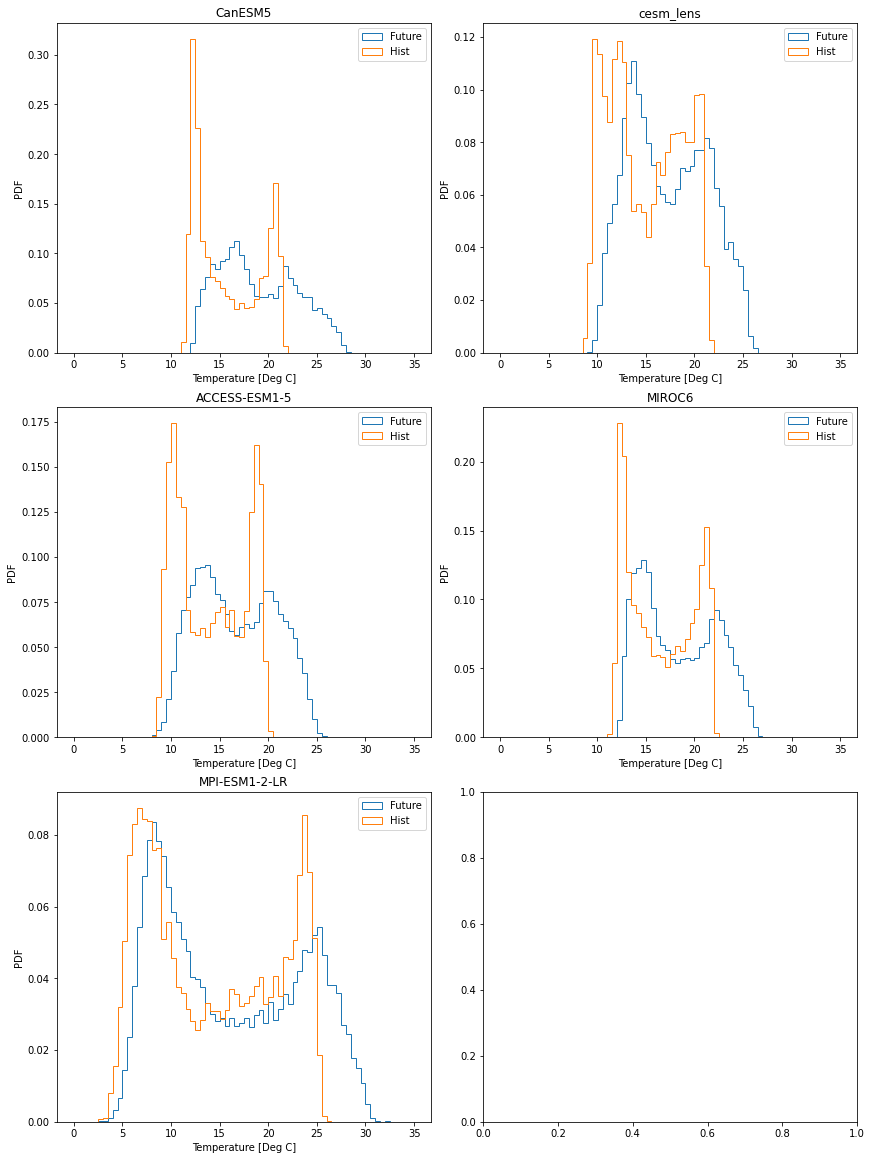

In [45]:
# make step PDF for all models 
dbins, bmin, bmax = 0.5, 0, 35
bins = np.arange(bmin,bmax+dbins,dbins)

fig, ax = plt.subplots(nrows=3, ncols=2, constrained_layout=True,figsize=(12,16))
axes = [ax[0,0],ax[0,1],ax[1,0],ax[1,1],ax[2,0],ax[2,1]]
models=['CanESM5','cesm_lens','ACCESS-ESM1-5','MIROC6','MPI-ESM1-2-LR']
for axe,model in zip(axes,models):
    axe.hist(USwest_future.sel(model=model),density=True, bins=bins,histtype='step',label='Future');
    axe.hist(USwest_hist.sel(model=model),density=True,bins=bins,histtype='step',label='Hist');
    axe.set_xlabel('Temperature [Deg C]')
    axe.set_ylabel('PDF')
    axe.set_title(model)
    axe.legend()

In [17]:
Q99 = []
Q99_percent = []
Q95 = []
Q95_percent = []
Q90 = []
Q90_percent = []
models = ['CanESM5','cesm_lens','ACCESS-ESM1-5','MIROC6','MPI-ESM1-2-LR']
for model in models:
    
    Q99.append(quantile_occurance(USwest_hist.sel(model=model),
                       USwest_future.sel(model=model),q=0.99)[0])
    Q99_percent.append(quantile_occurance(USwest_hist.sel(model=model),
                       USwest_future.sel(model=model),q=0.99)[1])
    Q95.append(quantile_occurance(USwest_hist.sel(model=model),
                       USwest_future.sel(model=model),q=0.95)[0])
    Q95_percent.append(quantile_occurance(USwest_hist.sel(model=model),
                       USwest_future.sel(model=model),q=0.95)[1])
    Q90.append(quantile_occurance(USwest_hist.sel(model=model),
                       USwest_future.sel(model=model),q=0.90)[0])
    Q90_percent.append(quantile_occurance(USwest_hist.sel(model=model),
                       USwest_future.sel(model=model),q=0.90)[1])

In [18]:
df = pd.DataFrame(data=[models,Q99,Q99_percent,Q95,Q95_percent,Q90,Q90_percent])
df = df.T
df = df.rename(columns={0:'Models',1:'99th Quantile [Deg C]',
                        2:'99thQ % Occurance',3:'95th Quantile [Deg C]',
                        4:'95thQ % Occurance',
                        5:'90th Quantile [Deg C]',6:'90thQ % Occurance'})
df

,Models,99th Quantile [Deg C],99thQ % Occurance,95th Quantile [Deg C],95thQ % Occurance,90th Quantile [Deg C],90thQ % Occurance
0,CanESM5,21.39,31.83,21.02,34.16,20.72,35.9
1,cesm_lens,21.16,21.74,20.66,25.55,20.19,29.23
2,ACCESS-ESM1-5,19.71,28.31,19.29,31.72,18.95,34.16
3,MIROC6,21.82,25.83,21.53,28.08,21.22,30.28
4,MPI-ESM1-2-LR,25.01,15.66,24.31,19.3,23.67,22.27


## Iceland

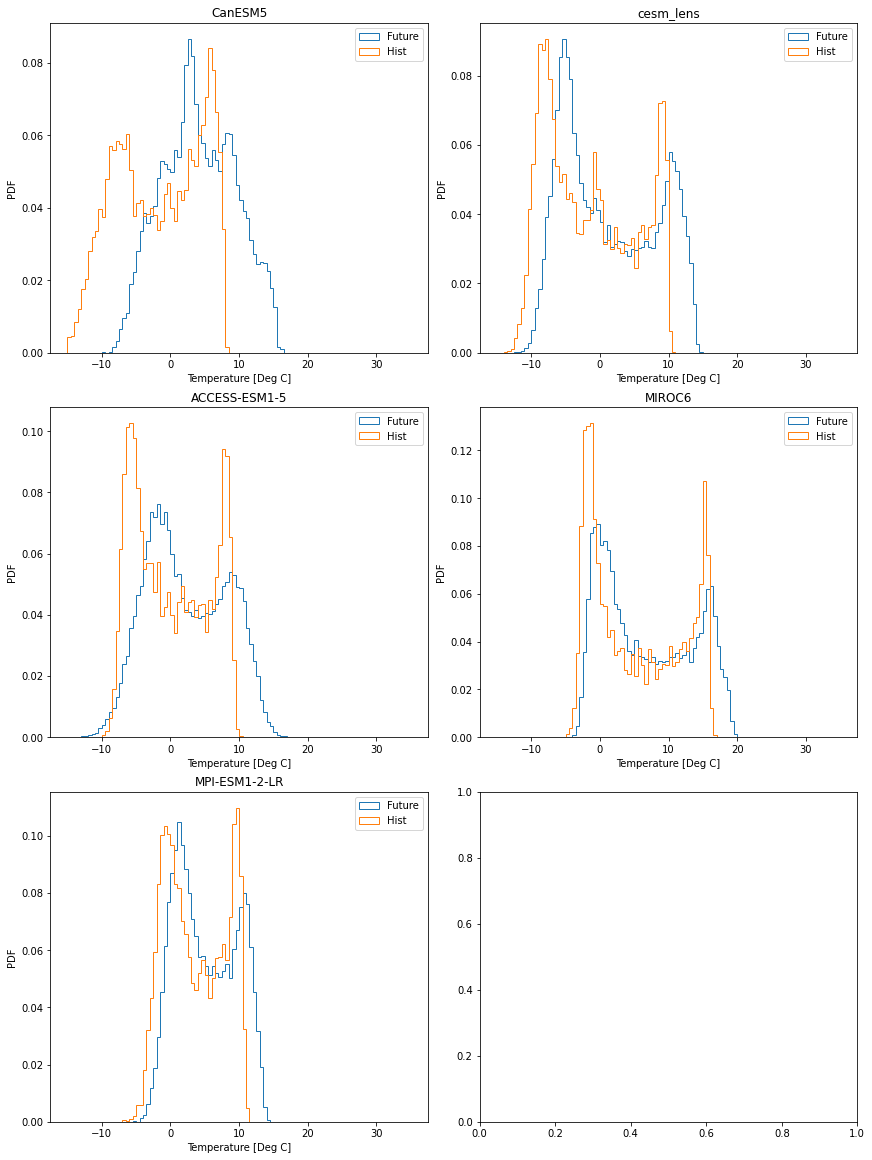

In [14]:
# make step PDF for all models 
dbins, bmin, bmax = 0.5, -15, 35
bins = np.arange(bmin,bmax+dbins,dbins)

fig, ax = plt.subplots(nrows=3, ncols=2, constrained_layout=True,figsize=(12,16))
axes = [ax[0,0],ax[0,1],ax[1,0],ax[1,1],ax[2,0],ax[2,1]]
models=['CanESM5','cesm_lens','ACCESS-ESM1-5','MIROC6','MPI-ESM1-2-LR']
for axe,model in zip(axes,models):
    axe.hist(iceland_future.sel(model=model),density=True, bins=bins,histtype='step',label='Future');
    axe.hist(iceland_hist.sel(model=model),density=True,bins=bins,histtype='step',label='Hist');
    axe.set_xlabel('Temperature [Deg C]')
    axe.set_ylabel('PDF')
    axe.set_title(model)
    axe.legend()

In [15]:
Q99 = []
Q99_percent = []
Q95 = []
Q95_percent = []
Q90 = []
Q90_percent = []
models = ['CanESM5','cesm_lens','ACCESS-ESM1-5','MIROC6','MPI-ESM1-2-LR']
for model in models:
    
    Q99.append(quantile_occurance(iceland_hist.sel(model=model),
                       iceland_future.sel(model=model),q=0.99)[0])
    Q99_percent.append(quantile_occurance(iceland_hist.sel(model=model),
                       iceland_future.sel(model=model),q=0.99)[1])
    Q95.append(quantile_occurance(iceland_hist.sel(model=model),
                       iceland_future.sel(model=model),q=0.95)[0])
    Q95_percent.append(quantile_occurance(iceland_hist.sel(model=model),
                       iceland_future.sel(model=model),q=0.95)[1])
    Q90.append(quantile_occurance(iceland_hist.sel(model=model),
                       iceland_future.sel(model=model),q=0.90)[0])
    Q90_percent.append(quantile_occurance(iceland_hist.sel(model=model),
                       iceland_future.sel(model=model),q=0.90)[1])

In [16]:
df = pd.DataFrame(data=[models,Q99,Q99_percent,Q95,Q95_percent,Q90,Q90_percent])
df = df.T
df = df.rename(columns={0:'Models',1:'99th Quantile [Deg C]',
                        2:'99thQ % Occurance',3:'95th Quantile [Deg C]',
                        4:'95thQ % Occurance',
                        5:'90th Quantile [Deg C]',6:'90thQ % Occurance'})
df

,Models,99th Quantile [Deg C],99thQ % Occurance,95th Quantile [Deg C],95thQ % Occurance,90th Quantile [Deg C],90thQ % Occurance
0,CanESM5,7.69,28.14,6.91,32.22,6.23,36.04
1,cesm_lens,9.84,17.24,9.24,20.1,8.56,22.74
2,ACCESS-ESM1-5,9.09,16.48,8.47,19.78,7.93,22.55
3,MIROC6,15.94,12.04,15.46,15.04,14.98,17.54
4,MPI-ESM1-2-LR,10.68,14.55,10.11,18.94,9.64,22.15


## Europe

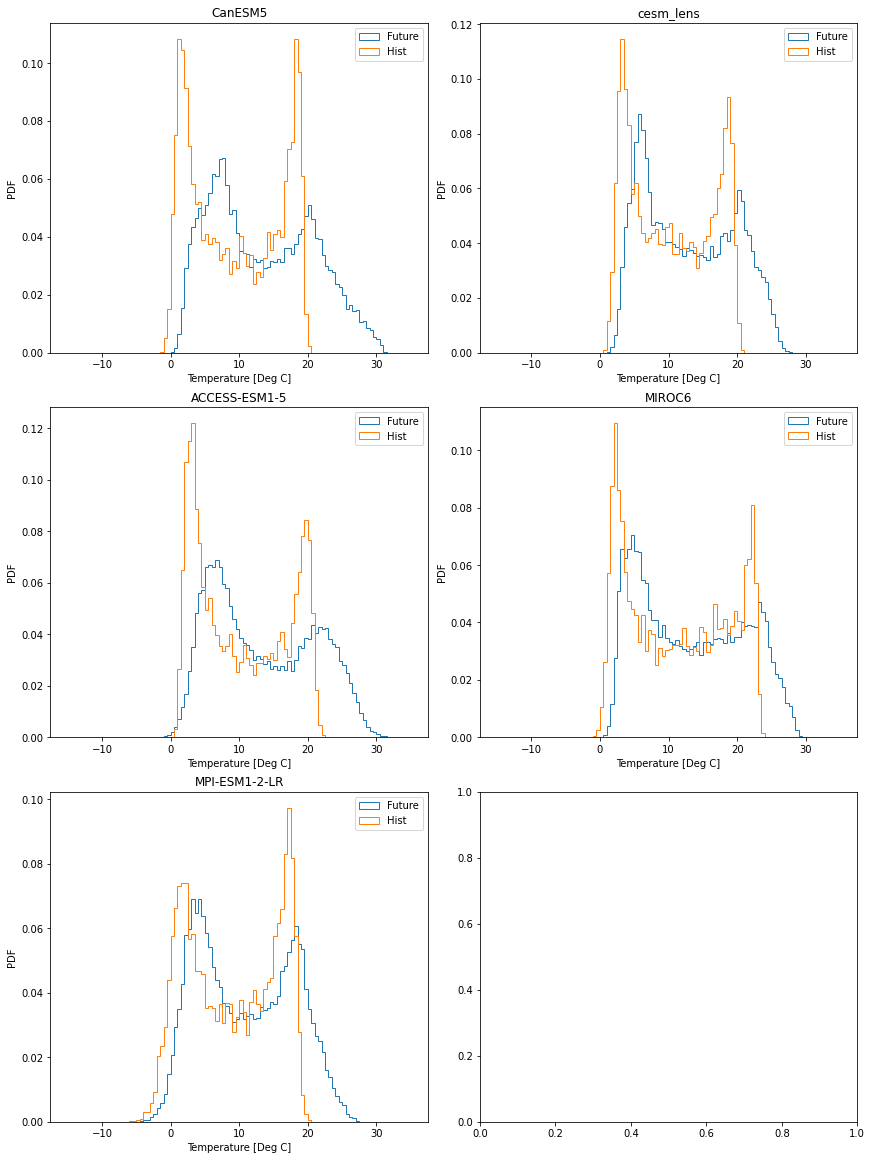

In [19]:
# make step PDF for all models 
dbins, bmin, bmax = 0.5, -15, 35
bins = np.arange(bmin,bmax+dbins,dbins)

fig, ax = plt.subplots(nrows=3, ncols=2, constrained_layout=True,figsize=(12,16))
axes = [ax[0,0],ax[0,1],ax[1,0],ax[1,1],ax[2,0],ax[2,1]]
models=['CanESM5','cesm_lens','ACCESS-ESM1-5','MIROC6','MPI-ESM1-2-LR']
for axe,model in zip(axes,models):
    axe.hist(europe_future.sel(model=model),density=True, bins=bins,histtype='step',label='Future');
    axe.hist(europe_hist.sel(model=model),density=True,bins=bins,histtype='step',label='Hist');
    axe.set_xlabel('Temperature [Deg C]')
    axe.set_ylabel('PDF')
    axe.set_title(model)
    axe.legend()

In [20]:
Q99 = []
Q99_percent = []
Q95 = []
Q95_percent = []
Q90 = []
Q90_percent = []
models = ['CanESM5','cesm_lens','ACCESS-ESM1-5','MIROC6','MPI-ESM1-2-LR']
for model in models:
    
    Q99.append(quantile_occurance(europe_hist.sel(model=model),
                       europe_future.sel(model=model),q=0.99)[0])
    Q99_percent.append(quantile_occurance(europe_hist.sel(model=model),
                       europe_future.sel(model=model),q=0.99)[1])
    Q95.append(quantile_occurance(europe_hist.sel(model=model),
                       europe_future.sel(model=model),q=0.95)[0])
    Q95_percent.append(quantile_occurance(europe_hist.sel(model=model),
                       europe_future.sel(model=model),q=0.95)[1])
    Q90.append(quantile_occurance(europe_hist.sel(model=model),
                       europe_future.sel(model=model),q=0.90)[0])
    Q90_percent.append(quantile_occurance(europe_hist.sel(model=model),
                       europe_future.sel(model=model),q=0.90)[1])

In [21]:
df = pd.DataFrame(data=[models,Q99,Q99_percent,Q95,Q95_percent,Q90,Q90_percent])
df = df.T
df = df.rename(columns={0:'Models',1:'99th Quantile [Deg C]',
                        2:'99thQ % Occurance',3:'95th Quantile [Deg C]',
                        4:'95thQ % Occurance',
                        5:'90th Quantile [Deg C]',6:'90thQ % Occurance'})
df

,Models,99th Quantile [Deg C],99thQ % Occurance,95th Quantile [Deg C],95thQ % Occurance,90th Quantile [Deg C],90thQ % Occurance
0,CanESM5,19.42,26.4,18.87,28.73,18.38,30.82
1,cesm_lens,19.82,21.15,19.17,24.28,18.61,26.63
2,ACCESS-ESM1-5,21.08,21.59,20.32,24.82,19.72,27.11
3,MIROC6,22.96,14.25,22.33,16.68,21.61,19.46
4,MPI-ESM1-2-LR,18.8,16.04,17.97,20.88,17.4,24.05


## Australia 

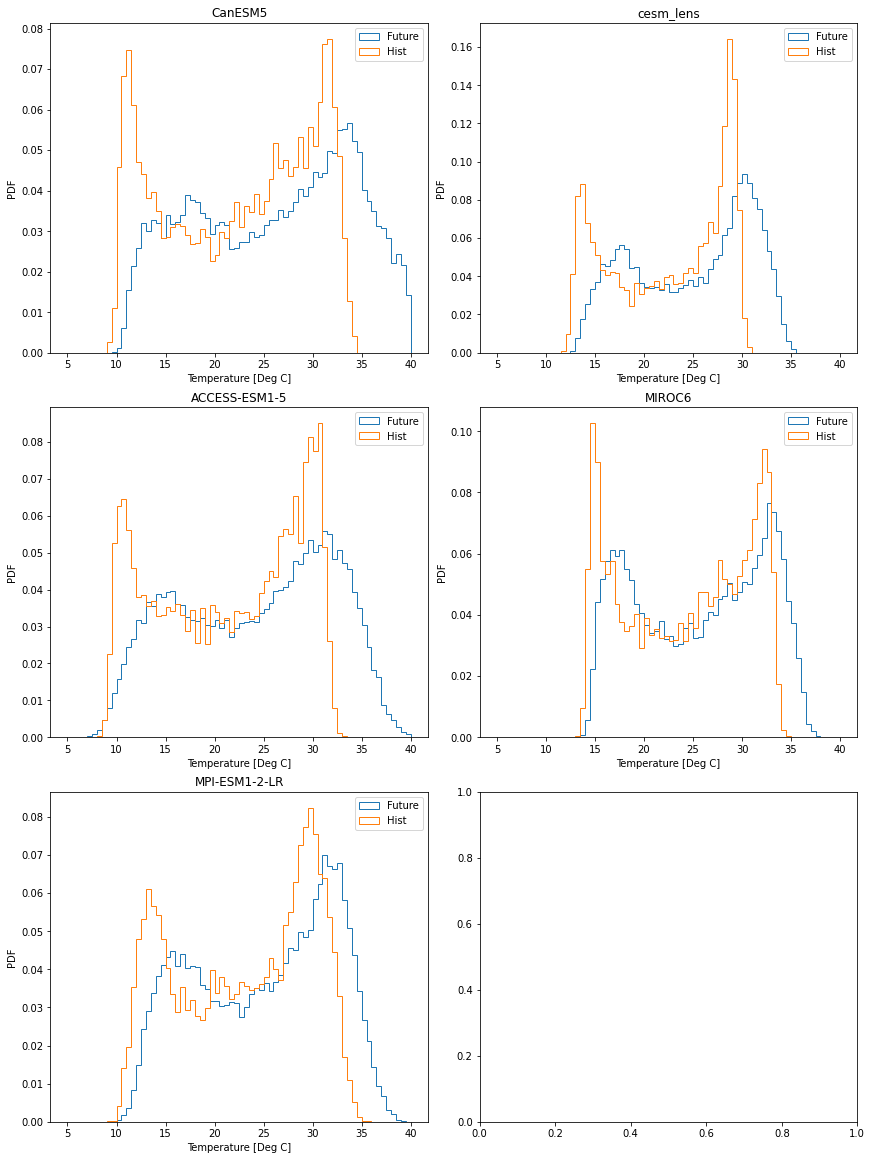

In [23]:
# make step PDF for all models 
dbins, bmin, bmax = 0.5, 5, 40
bins = np.arange(bmin,bmax+dbins,dbins)

fig, ax = plt.subplots(nrows=3, ncols=2, constrained_layout=True,figsize=(12,16))
axes = [ax[0,0],ax[0,1],ax[1,0],ax[1,1],ax[2,0],ax[2,1]]
models=['CanESM5','cesm_lens','ACCESS-ESM1-5','MIROC6','MPI-ESM1-2-LR']
for axe,model in zip(axes,models):
    axe.hist(australia_future.sel(model=model),density=True, bins=bins,histtype='step',label='Future');
    axe.hist(australia_hist.sel(model=model),density=True,bins=bins,histtype='step',label='Hist');
    axe.set_xlabel('Temperature [Deg C]')
    axe.set_ylabel('PDF')
    axe.set_title(model)
    axe.legend()

In [24]:
Q99 = []
Q99_percent = []
Q95 = []
Q95_percent = []
Q90 = []
Q90_percent = []
models = ['CanESM5','cesm_lens','ACCESS-ESM1-5','MIROC6','MPI-ESM1-2-LR']
for model in models:
    
    Q99.append(quantile_occurance(australia_hist.sel(model=model),
                       australia_future.sel(model=model),q=0.99)[0])
    Q99_percent.append(quantile_occurance(australia_hist.sel(model=model),
                       australia_future.sel(model=model),q=0.99)[1])
    Q95.append(quantile_occurance(australia_hist.sel(model=model),
                       australia_future.sel(model=model),q=0.95)[0])
    Q95_percent.append(quantile_occurance(australia_hist.sel(model=model),
                       australia_future.sel(model=model),q=0.95)[1])
    Q90.append(quantile_occurance(australia_hist.sel(model=model),
                       australia_future.sel(model=model),q=0.90)[0])
    Q90_percent.append(quantile_occurance(australia_hist.sel(model=model),
                       australia_future.sel(model=model),q=0.90)[1])

In [25]:
df = pd.DataFrame(data=[models,Q99,Q99_percent,Q95,Q95_percent,Q90,Q90_percent])
df = df.T
df = df.rename(columns={0:'Models',1:'99th Quantile [Deg C]',
                        2:'99thQ % Occurance',3:'95th Quantile [Deg C]',
                        4:'95thQ % Occurance',
                        5:'90th Quantile [Deg C]',6:'90thQ % Occurance'})
df

,Models,99th Quantile [Deg C],99thQ % Occurance,95th Quantile [Deg C],95thQ % Occurance,90th Quantile [Deg C],90thQ % Occurance
0,CanESM5,33.43,23.93,32.45,29.18,31.7,32.89
1,cesm_lens,30.02,27.38,29.48,32.23,29.13,35.1
2,ACCESS-ESM1-5,31.72,20.56,30.91,25.03,30.31,28.09
3,MIROC6,33.5,12.73,32.85,17.5,32.28,21.69
4,MPI-ESM1-2-LR,33.42,11.07,32.12,19.45,31.24,25.47


## Tropics

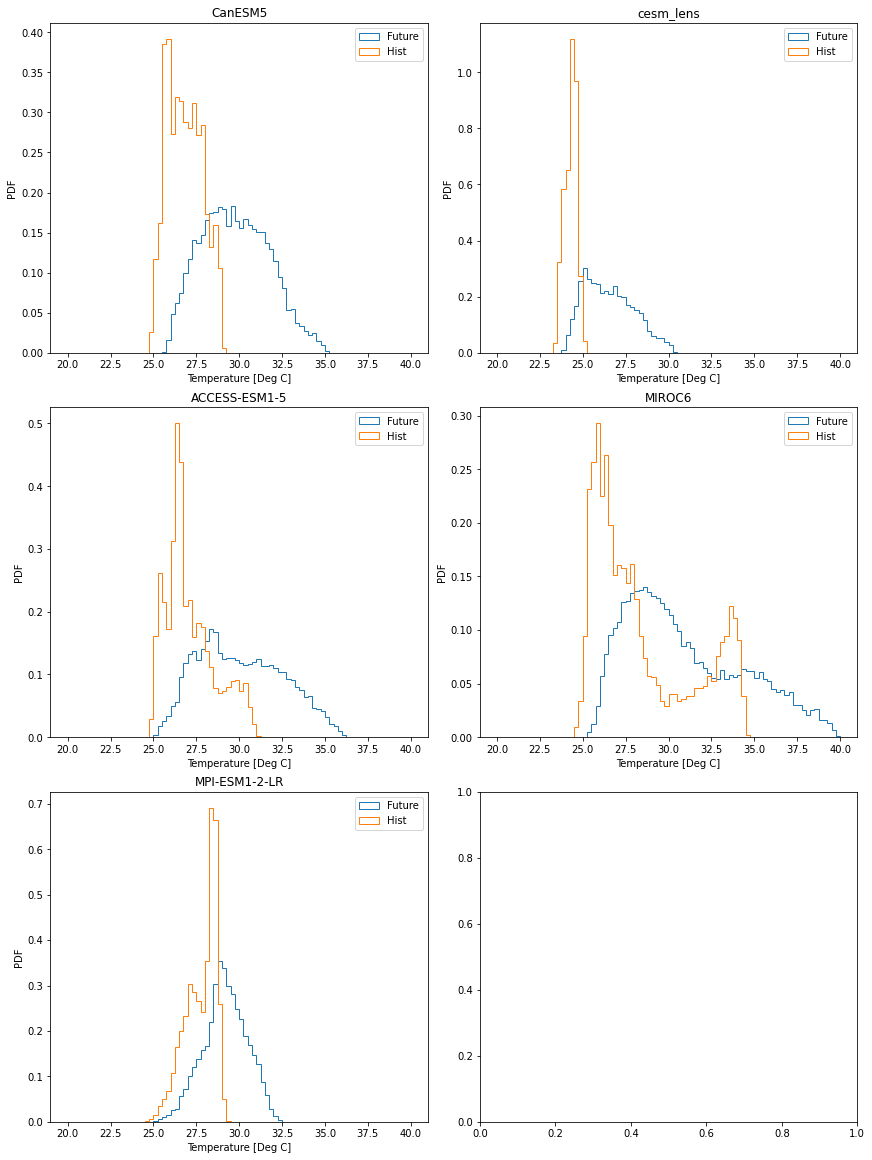

In [29]:
# make step PDF for all models 
dbins, bmin, bmax = 0.25, 20, 40
bins = np.arange(bmin,bmax+dbins,dbins)

fig, ax = plt.subplots(nrows=3, ncols=2, constrained_layout=True,figsize=(12,16))
axes = [ax[0,0],ax[0,1],ax[1,0],ax[1,1],ax[2,0],ax[2,1]]
models=['CanESM5','cesm_lens','ACCESS-ESM1-5','MIROC6','MPI-ESM1-2-LR']
for axe,model in zip(axes,models):
    axe.hist(tropics_future.sel(model=model),density=True, bins=bins,histtype='step',label='Future');
    axe.hist(tropics_hist.sel(model=model),density=True,bins=bins,histtype='step',label='Hist');
    axe.set_xlabel('Temperature [Deg C]')
    axe.set_ylabel('PDF')
    axe.set_title(model)
    axe.legend()

In [30]:
Q99 = []
Q99_percent = []
Q95 = []
Q95_percent = []
Q90 = []
Q90_percent = []
models = ['CanESM5','cesm_lens','ACCESS-ESM1-5','MIROC6','MPI-ESM1-2-LR']
for model in models:
    
    Q99.append(quantile_occurance(tropics_hist.sel(model=model),
                       tropics_future.sel(model=model),q=0.99)[0])
    Q99_percent.append(quantile_occurance(tropics_hist.sel(model=model),
                       tropics_future.sel(model=model),q=0.99)[1])
    Q95.append(quantile_occurance(tropics_hist.sel(model=model),
                       tropics_future.sel(model=model),q=0.95)[0])
    Q95_percent.append(quantile_occurance(tropics_hist.sel(model=model),
                       tropics_future.sel(model=model),q=0.95)[1])
    Q90.append(quantile_occurance(tropics_hist.sel(model=model),
                       tropics_future.sel(model=model),q=0.90)[0])
    Q90_percent.append(quantile_occurance(tropics_hist.sel(model=model),
                       tropics_future.sel(model=model),q=0.90)[1])

In [31]:
df = pd.DataFrame(data=[models,Q99,Q99_percent,Q95,Q95_percent,Q90,Q90_percent])
df = df.T
df = df.rename(columns={0:'Models',1:'99th Quantile [Deg C]',
                        2:'99thQ % Occurance',3:'95th Quantile [Deg C]',
                        4:'95thQ % Occurance',
                        5:'90th Quantile [Deg C]',6:'90thQ % Occurance'})
df

,Models,99th Quantile [Deg C],99thQ % Occurance,95th Quantile [Deg C],95thQ % Occurance,90th Quantile [Deg C],90thQ % Occurance
0,CanESM5,28.89,63.68,28.61,68.48,28.26,74.59
1,cesm_lens,25.0,84.58,24.82,89.33,24.71,91.83
2,ACCESS-ESM1-5,30.61,41.35,30.1,47.31,29.53,54.27
3,MIROC6,34.25,20.87,33.84,23.22,33.41,25.67
4,MPI-ESM1-2-LR,29.03,54.41,28.82,61.98,28.71,65.6


### other things


In [ ]:
test = hist.resample(time='QS-DEC').mean(dim="time")

In [ ]:
test

<xarray.DataArray 'tas' (model: 6, time: 81)>
array([[ 5.3889775 , 12.421143  , 23.519054  , 17.670557  ,  6.1154943 ,
        12.253522  , 23.595554  , 17.951286  ,  6.0221705 , 12.240929  ,
        23.461489  , 17.901217  ,  6.255219  , 12.369228  , 23.717157  ,
        18.065588  ,  6.1028056 , 12.283319  , 23.86881   , 18.310976  ,
         6.190738  , 12.466016  , 24.001406  , 18.344828  ,  6.649366  ,
        12.449303  , 23.89972   , 18.081638  ,  6.209307  , 12.464382  ,
        24.101542  , 18.42034   ,  6.4672704 , 12.683472  , 24.337355  ,
        18.44666   ,  6.723283  , 12.852983  , 24.229105  , 18.406212  ,
         6.631439  , 12.519141  , 24.100199  , 18.406025  ,  6.148802  ,
        12.493465  , 24.265736  , 18.547827  ,  6.7439737 , 12.838307  ,
        24.383896  , 18.344006  ,  6.714248  , 12.827844  , 24.378433  ,
        18.613176  ,  6.6211033 , 12.770837  , 24.36135   , 18.604097  ,
         7.1455336 , 12.838657  , 24.399021  , 18.566847  ,  6.8328314 ,
        13.038822  , 24.436264  , 18.593044  ,  6.4288425 , 12.971199  ,
        24.750032  , 19.072132  ,  7.2608776 , 13.066963  , 24.715252  ,
        19.073483  ,  7.0293593 , 13.139617  , 24.722767  , 18.975927  ,
         9.032794  ],
       [ 3.2493782 , 13.117633  , 23.498236  , 16.109268  ,  3.5353794 ,
        12.911781  , 23.38728   , 16.457064  ,  3.7384295 , 12.959019  ,
        23.478733  , 16.528212  ,  4.1648064 , 13.056077  , 23.50033   ,
...
        19.99244   ,  9.82164   , -4.4246902 ,  7.270682  , 19.911375  ,
         9.84376   , -4.1645784 ,  6.971112  , 19.40137   , 10.070243  ,
        -2.3981965 ],
       [-0.92359865,  8.202059  , 20.323658  , 14.416582  ,  1.2498602 ,
         8.38526   , 20.767332  , 14.257117  ,  0.0506652 ,  7.9869485 ,
        20.904142  , 14.884956  ,  1.0501567 ,  8.502099  , 20.804373  ,
        14.305363  ,  1.9312311 ,  8.3909855 , 21.02156   , 14.676196  ,
         0.5849316 ,  9.10395   , 21.04083   , 14.284428  ,  1.7882419 ,
         9.168927  , 21.47552   , 14.645045  ,  1.0798507 ,  8.682464  ,
        21.525743  , 14.7699995 ,  1.7163572 ,  8.279002  , 21.027979  ,
        14.983221  ,  0.6949413 ,  8.726492  , 21.029451  , 14.640873  ,
         1.7772866 ,  8.87118   , 21.17779   , 14.827578  ,  1.2331318 ,
         8.7232065 , 21.164257  , 14.794355  ,  1.7102729 ,  9.306789  ,
        20.977724  , 14.898246  ,  2.3268735 ,  9.371054  , 21.407234  ,
        14.338533  ,  1.0282855 ,  8.99848   , 20.925795  , 14.40397   ,
         2.4833484 ,  8.39274   , 21.116869  , 15.192316  ,  2.3828704 ,
         9.298675  , 21.511095  , 15.257402  ,  1.4495533 ,  8.839975  ,
        21.657478  , 14.781975  ,  2.5924509 ,  9.877211  , 21.71317   ,
        15.267967  ,  2.6646895 ,  9.98894   , 21.526974  , 15.428708  ,
         4.979154  ]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1994-12-01 1995-03-01 ... 2014-12-01
  * model    (model) <U13 'CanESM5' 'cesm_lens' ... 'MPI-ESM1-2-LR' 'EC-Earth3'

In [ ]:
test = test.T

In [ ]:
test[0::4]

<xarray.DataArray 'tas' (time: 21, model: 6)>
array([[ 5.3889775 ,  3.2493782 ,  3.5410645 ,  0.9553093 , -5.619478  ,
        -0.92359865],
       [ 6.1154943 ,  3.5353794 ,  4.1296315 ,  1.537374  , -4.548939  ,
         1.2498602 ],
       [ 6.0221705 ,  3.7384295 ,  3.7353008 ,  1.6958647 , -4.5392494 ,
         0.0506652 ],
       [ 6.255219  ,  4.1648064 ,  3.9148898 ,  1.7817595 , -6.6889424 ,
         1.0501567 ],
       [ 6.1028056 ,  4.289512  ,  3.8859334 ,  1.588828  , -5.8957534 ,
         1.9312311 ],
       [ 6.190738  ,  3.9120786 ,  4.4672046 ,  2.0371857 , -5.463931  ,
         0.5849316 ],
       [ 6.649366  ,  3.6446886 ,  4.0923104 ,  1.7554657 , -4.3594985 ,
         1.7882419 ],
       [ 6.209307  ,  4.2352395 ,  4.332878  ,  1.9357368 , -5.2484775 ,
         1.0798507 ],
       [ 6.4672704 ,  4.2550936 ,  3.7541945 ,  1.4977663 , -5.052647  ,
         1.7163572 ],
       [ 6.723283  ,  3.7460277 ,  4.0806775 ,  1.9667131 , -5.428158  ,
         0.6949413 ],
...
       [ 6.148802  ,  4.4798217 ,  4.3731136 ,  2.0809631 , -3.4146512 ,
         1.2331318 ],
       [ 6.7439737 ,  4.590367  ,  4.0819745 ,  2.0846217 , -4.494857  ,
         1.7102729 ],
       [ 6.714248  ,  3.999633  ,  4.322844  ,  1.966681  , -5.1878514 ,
         2.3268735 ],
       [ 6.6211033 ,  4.322688  ,  4.448585  ,  2.5648048 , -5.084175  ,
         1.0282855 ],
       [ 7.1455336 ,  4.622472  ,  4.09562   ,  2.5288277 , -4.666346  ,
         2.4833484 ],
       [ 6.8328314 ,  4.6351833 ,  4.3899965 ,  2.431644  , -4.668864  ,
         2.3828704 ],
       [ 6.4288425 ,  4.6355834 ,  4.4776425 ,  1.8497351 , -4.997234  ,
         1.4495533 ],
       [ 7.2608776 ,  4.301463  ,  4.2000947 ,  2.3255167 , -4.4246902 ,
         2.5924509 ],
       [ 7.0293593 ,  4.6641393 ,  4.1254315 ,  2.1809983 , -4.1645784 ,
         2.6646895 ],
       [ 9.032794  ,  5.5227823 ,  5.7215447 ,  3.7714021 , -2.3981965 ,
         4.979154  ]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1994-12-01 1995-12-01 ... 2014-12-01
  * model    (model) <U13 'CanESM5' 'cesm_lens' ... 'MPI-ESM1-2-LR' 'EC-Earth3'

In [ ]:
DJF = test[0::4]
MAM = test[1::4]
JJA = test[2::4]
SON = test[3::4]

In [ ]:
JJA

<xarray.DataArray 'time' (time: 20)>
array(['1995-06-01T00:00:00.000000000', '1996-06-01T00:00:00.000000000',
       '1997-06-01T00:00:00.000000000', '1998-06-01T00:00:00.000000000',
       '1999-06-01T00:00:00.000000000', '2000-06-01T00:00:00.000000000',
       '2001-06-01T00:00:00.000000000', '2002-06-01T00:00:00.000000000',
       '2003-06-01T00:00:00.000000000', '2004-06-01T00:00:00.000000000',
       '2005-06-01T00:00:00.000000000', '2006-06-01T00:00:00.000000000',
       '2007-06-01T00:00:00.000000000', '2008-06-01T00:00:00.000000000',
       '2009-06-01T00:00:00.000000000', '2010-06-01T00:00:00.000000000',
       '2011-06-01T00:00:00.000000000', '2012-06-01T00:00:00.000000000',
       '2013-06-01T00:00:00.000000000', '2014-06-01T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1995-06-01 1996-06-01 ... 2014-06-01